# **1. Load Dataset & Exploratory Data Analysis (EDA)**  
- Dataset from kaggle : https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction  

Before we arrived in Exploratory Data Analysis, we did as we called `Dataset Preparations`. This `Dataset Preparations` have step as following  
1. We've tried to import raw dataset directly using Python Library `(Pandas)` but we encountered problems due to our less sufficiency memory size. We decided to use another method
2. We decided to do formatting the raw CSV dataset using both Microsoft Excel and SQL combined. 
3. First, we did CSV formatting using Microsoft Excel, replaced the blank values with Null to avoid truncated data warning in SQL, removed thousand separator and then saved it.
4. After that, we imported the formatted CSV to SQL using `LOAD DATA INFILE` Query. The query was succesfull. In the end, we got 6 tables in 1 schema as equal to 6 raw CSV data we received
5. After we joined some tables, we exported them into new sql and csv data. Then we proceed to Exploratory Data Analysis step. We decided to limit data rows for 15000 rows due to efficiency reason

In [1]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import warnings

warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/Credit scoring/precredit_train.csv', sep=';') #import dataset
df = df.drop(['NULL', 'MyUnknownColumn', 'LN_ID.1', 'MyUnknownColumn.1', 
              'SK_ID_PREV.1', 'LN_ID.2', 'CONTRACT_STATUS'], axis=1) #drop unnecessary feature
df = df.rename(columns={'CONTRACT_TYPE.1' : 'CONTRACT_TYPE_PREV_APP', 'ANNUITY.1' : 'ANNUITY_PREV_APP', 
                        'PRICE.1':'PRICE_PREV_APP', 'WEEKDAYS_APPLY.1':'WEEKKDAYS_APPLY_PREV_APP', 
                        'HOUR_APPLY.1': 'HOUR_APPLY_PREV_APP', 'APPROVED_CREDIT.1':'APPROVED_CREDIT_PREV_APP'}, 
                        inplace=False) #rename feature
df.head()

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,...,PRICE_PREV_APP,WEEKKDAYS_APPLY_PREV_APP,HOUR_APPLY_PREV_APP,DAYS_DECISION,TERM_PAYMENT,YIELD_GROUP,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,145235,0,Cash loans,M,0,202500.0,728460.0,44694.0,675000.0,Commercial associate,...,62955.0,SUNDAY,11.0,-261.0,8.0,low_normal,365243.0,-231.0,-16.0,1.0
1,156401,0,Cash loans,F,1,225000.0,640080.0,31261.5,450000.0,Working,...,64039.5,FRIDAY,16.0,-978.0,4.0,middle,365243.0,-947.0,-850.0,0.0
2,169487,0,Cash loans,M,0,202500.0,360000.0,NaN,360000.0,Working,...,270000.0,SATURDAY,10.0,-378.0,0.0,NA1,-365.0,-335.0,365243.0,0.0
3,230261,0,Cash loans,F,0,94500.0,148365.0,10453.5,135000.0,Working,...,41625.0,SATURDAY,11.0,-496.0,6.0,middle,365243.0,-465.0,-313.0,0.0
4,272288,0,Cash loans,F,0,157500.0,281493.0,10561.5,243000.0,Pensioner,...,1174500.0,WEDNESDAY,14.0,-449.0,54.0,low_normal,365243.0,-419.0,365243.0,1.0


In [4]:
print(df.shape)
print(df.info())

(61503, 44)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61503 entries, 0 to 61502
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   LN_ID                      61503 non-null  int64  
 1   TARGET                     61503 non-null  int64  
 2   CONTRACT_TYPE              61503 non-null  object 
 3   GENDER                     61503 non-null  object 
 4   NUM_CHILDREN               61503 non-null  int64  
 5   INCOME                     61503 non-null  float64
 6   APPROVED_CREDIT            61503 non-null  float64
 7   ANNUITY                    61502 non-null  float64
 8   PRICE                      61441 non-null  float64
 9   INCOME_TYPE                61503 non-null  object 
 10  EDUCATION                  61503 non-null  object 
 11  FAMILY_STATUS              61503 non-null  object 
 12  HOUSING_TYPE               61503 non-null  object 
 13  DAYS_AGE                   61503 n

## **Descriptive Analysis**

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LN_ID,61503.0,2.781511e+05,1.029182e+05,1.000090e+05,1.887670e+05,2.783570e+05,3.674245e+05,4.562550e+05
TARGET,61503.0,8.079281e-02,2.725189e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
NUM_CHILDREN,61503.0,4.118498e-01,7.166863e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,9.000000e+00
INCOME,61503.0,1.721919e+05,7.836493e+05,2.610000e+04,1.125000e+05,1.485000e+05,2.025000e+05,1.916515e+08
APPROVED_CREDIT,61503.0,5.976899e+05,4.016493e+05,4.500000e+04,2.700000e+05,5.124465e+05,8.086500e+05,4.050000e+06
ANNUITY,61502.0,2.708332e+04,1.447051e+04,2.164500e+03,1.650600e+04,2.485350e+04,3.459600e+04,2.580255e+05
PRICE,61441.0,5.369033e+05,3.685742e+05,4.500000e+04,2.385000e+05,4.500000e+05,6.795000e+05,4.050000e+06
DAYS_AGE,61503.0,-1.605748e+04,4.363537e+03,-2.522900e+04,-1.971650e+04,-1.575300e+04,-1.245000e+04,-7.673000e+03
DAYS_WORK,61503.0,6.488226e+04,1.421544e+05,-1.791200e+04,-2.761000e+03,-1.208000e+03,-2.760000e+02,3.652430e+05
DAYS_REGISTRATION,61503.0,-4.976696e+03,3.520926e+03,-2.292800e+04,-7.479000e+03,-4.498000e+03,-1.996000e+03,0.000000e+00


In [6]:
df.skew()

LN_ID                         -0.004960
TARGET                         3.076637
NUM_CHILDREN                   1.831185
INCOME                       237.488629
APPROVED_CREDIT                1.228191
ANNUITY                        1.560878
PRICE                          1.339185
DAYS_AGE                      -0.112140
DAYS_WORK                      1.639126
DAYS_REGISTRATION             -0.584696
DAYS_ID_CHANGE                 0.347033
HOUR_APPLY                    -0.024081
EXT_SCORE_1                   -0.077530
EXT_SCORE_3                   -0.405883
SK_ID_PREV                     0.044819
INST_NUMBER                    6.439665
INST_DAYS                     -0.874692
PAY_DAYS                      -0.871902
ANNUITY_PREV_APP               3.467142
APPLICATION                   19.880152
APPROVED_CREDIT_PREV_APP      73.547934
AMT_DOWN_PAYMENT              23.430452
PRICE_PREV_APP                19.603168
HOUR_APPLY_PREV_APP           -0.042848
DAYS_DECISION                 -0.822930


In [7]:
def countplot_applicants(features):
    for feature in features:
        plt.figure(figsize=(9, 9))
        ax=sns.countplot(y=df[feature], hue='GENDER' , data=df)
        plt.legend(loc='best')
        total = len(df[feature])
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
    plt.show()

In [8]:
df.columns

Index(['LN_ID', 'TARGET', 'CONTRACT_TYPE', 'GENDER', 'NUM_CHILDREN', 'INCOME',
       'APPROVED_CREDIT', 'ANNUITY', 'PRICE', 'INCOME_TYPE', 'EDUCATION',
       'FAMILY_STATUS', 'HOUSING_TYPE', 'DAYS_AGE', 'DAYS_WORK',
       'DAYS_REGISTRATION', 'DAYS_ID_CHANGE', 'WEEKDAYS_APPLY', 'HOUR_APPLY',
       'ORGANIZATION_TYPE', 'EXT_SCORE_1', 'EXT_SCORE_2', 'EXT_SCORE_3',
       'SK_ID_PREV', 'INST_NUMBER', 'INST_DAYS', 'PAY_DAYS', 'AMT_INST',
       'AMT_PAY', 'CONTRACT_TYPE_PREV_APP', 'ANNUITY_PREV_APP', 'APPLICATION',
       'APPROVED_CREDIT_PREV_APP', 'AMT_DOWN_PAYMENT', 'PRICE_PREV_APP',
       'WEEKKDAYS_APPLY_PREV_APP', 'HOUR_APPLY_PREV_APP', 'DAYS_DECISION',
       'TERM_PAYMENT', 'YIELD_GROUP', 'FIRST_DRAW', 'FIRST_DUE', 'TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

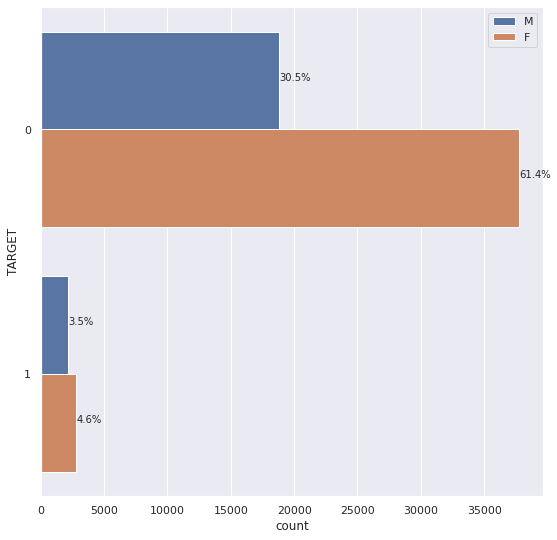

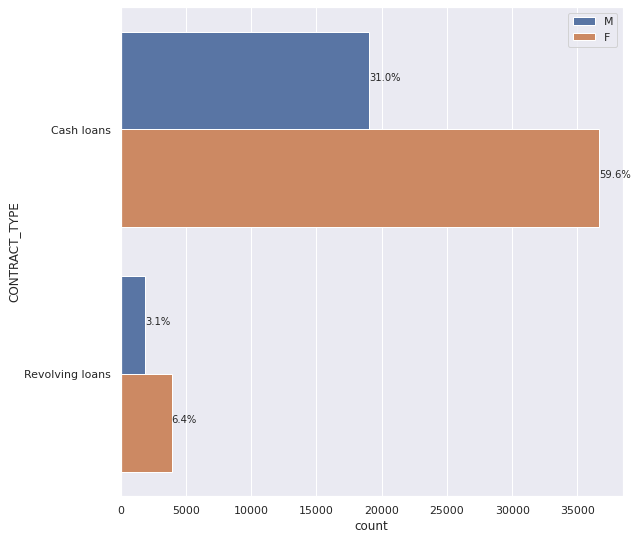

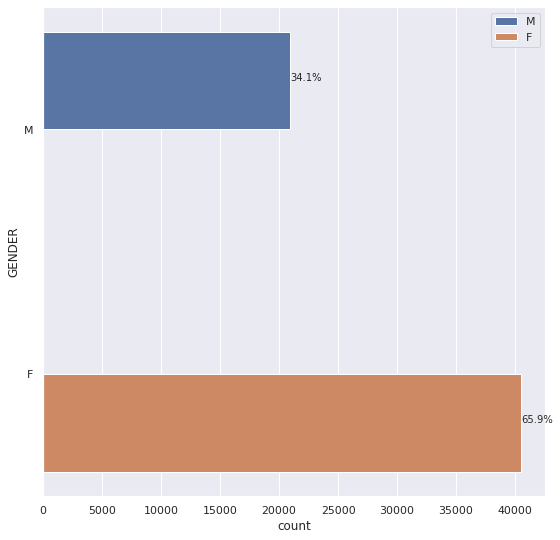

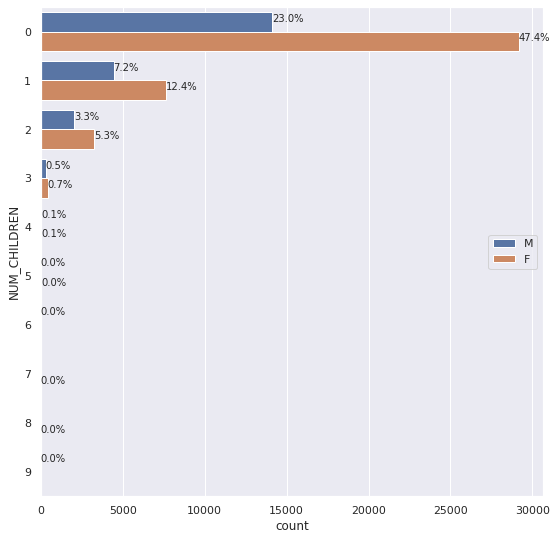

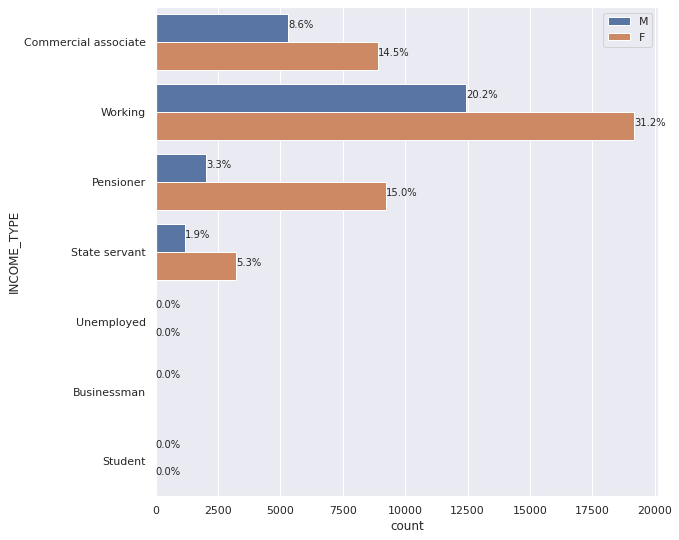

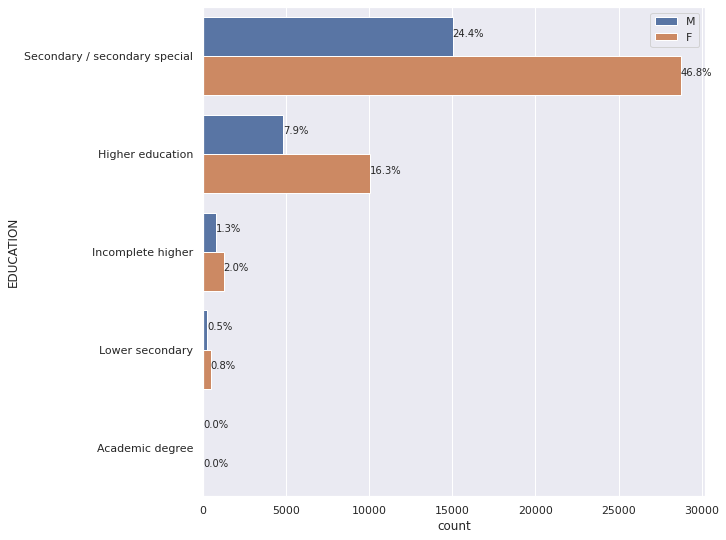

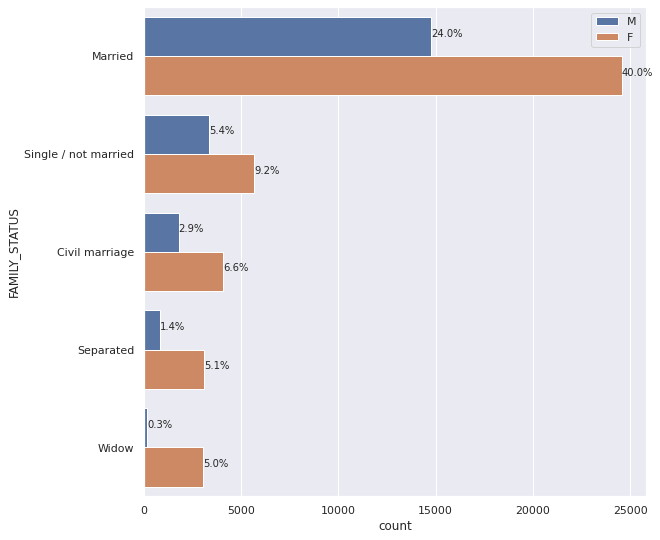

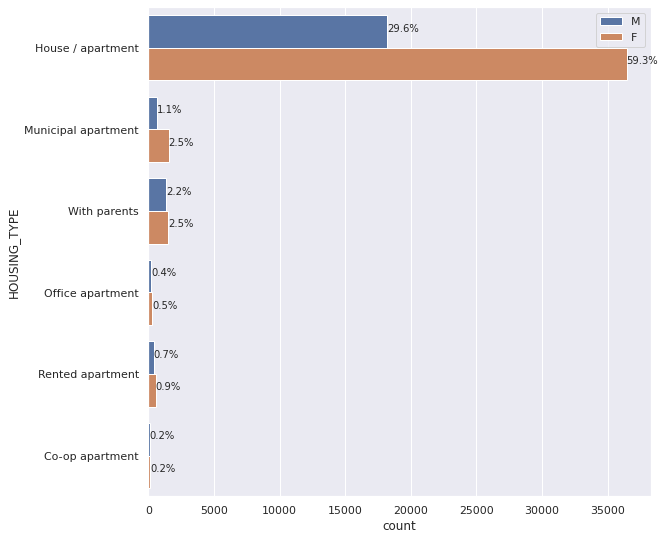

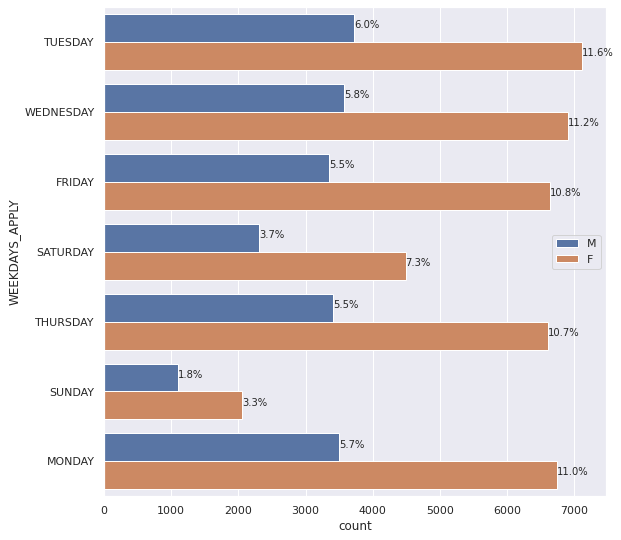

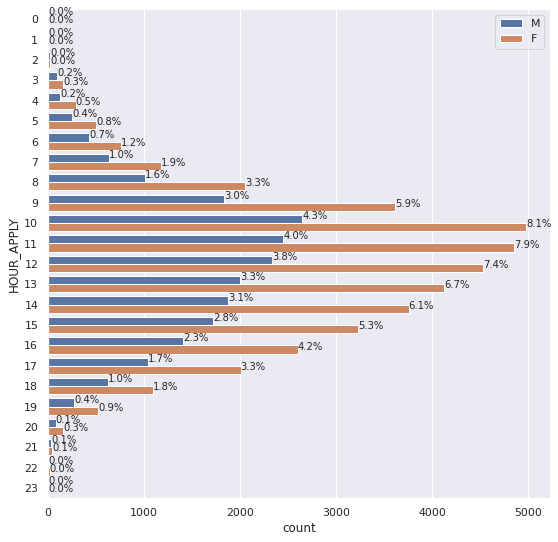

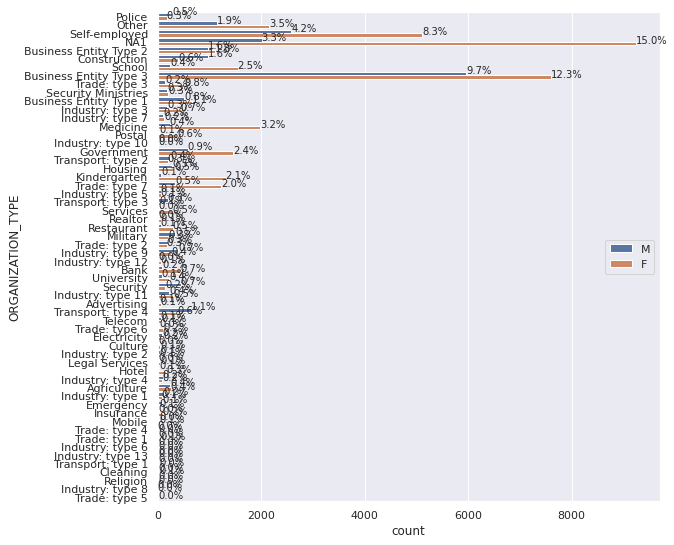

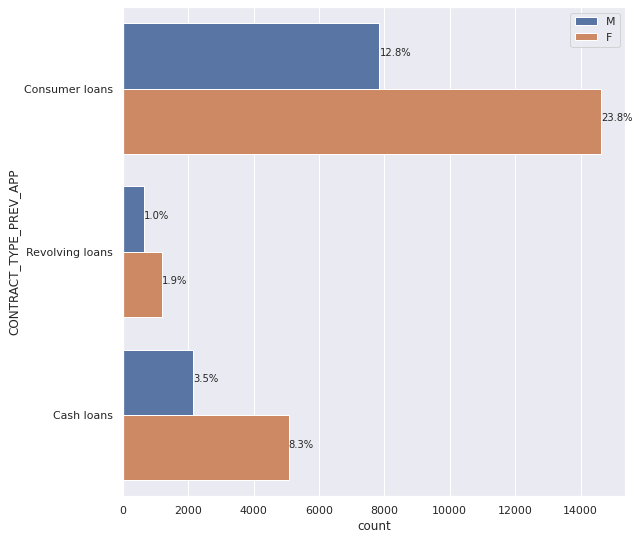

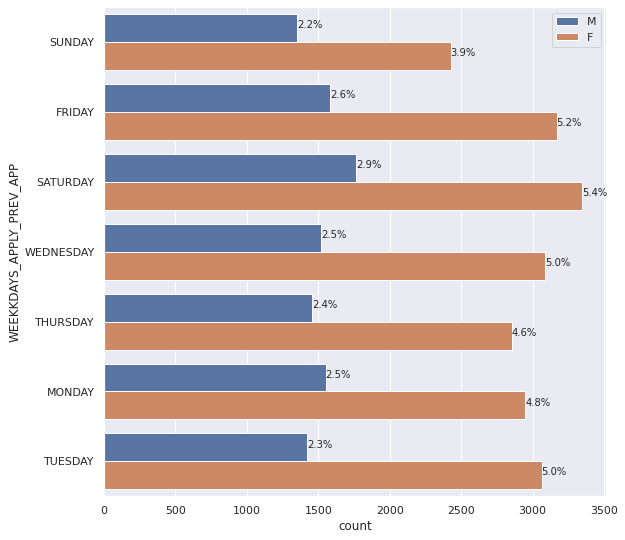

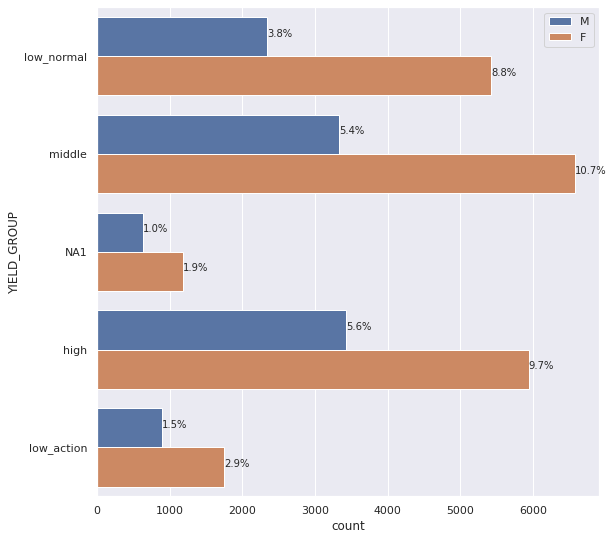

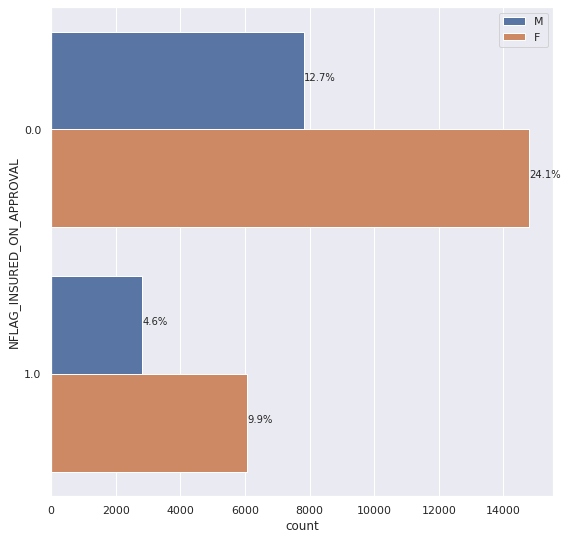

In [9]:
countplot_applicants(['TARGET', 'CONTRACT_TYPE', 'GENDER', 'NUM_CHILDREN',
                      'INCOME_TYPE', 'EDUCATION', 'FAMILY_STATUS', 'HOUSING_TYPE', 
                      'WEEKDAYS_APPLY', 'HOUR_APPLY', 'ORGANIZATION_TYPE', 'CONTRACT_TYPE_PREV_APP',
                      'WEEKKDAYS_APPLY_PREV_APP', 'YIELD_GROUP', 'NFLAG_INSURED_ON_APPROVAL'])
# 'LN_ID', 'INCOME', 'APPROVED_CREDIT', 'ANNUITY', 'PRICE', 'DAYS_AGE', 'DAYS_WORK', 'DAYS_REGISTRATION', 'DAYS_ID_CHANGE', 
# 'EXT_SCORE_1', 'EXT_SCORE_2', 'EXT_SCORE_3', 'SK_ID_PREV', 'INST_NUMBER', 'INST_DAYS', 'PAY_DAYS', 'AMT_INST', 'AMT_PAY',
# 'ANNUITY_PREV_APP', 'APPLICATION', 'APPROVED_CREDIT_PREV_APP', 'AMT_DOWN_PAYMENT', 'PRICE_PREV_APP',
# 'HOUR_APPLY_PREV_APP', 'DAYS_DECISION', 'TERM_PAYMENT',  'FIRST_DRAW', 'FIRST_DUE', 'TERMINATION',

## **Client Profiling**

**1. Who are our Clients (by gender)?**

In [10]:
df['GENDER'].value_counts()

F    40549
M    20954
Name: GENDER, dtype: int64

**2. How many Children that usually our clients have?**

In [11]:
df['NUM_CHILDREN'].value_counts()

0    43295
1    12083
2     5284
3      731
4       78
5       25
6        3
7        2
8        1
9        1
Name: NUM_CHILDREN, dtype: int64

**3. What are the income type that usually our clients have?**

In [12]:
df['INCOME_TYPE'].value_counts()

Working                 31621
Commercial associate    14217
Pensioner               11249
State servant            4407
Unemployed                  5
Student                     3
Businessman                 1
Name: INCOME_TYPE, dtype: int64

We could do Client Profiling with Exploratory Data Analysis as many as we need. There will be unlimited trial and experiment for this section. We decided to proceed to Clients Behaviour section

**Client Behaviour**

**1. On what days do usually our Clients apply the loan?**

In [13]:
df['WEEKDAYS_APPLY'].value_counts()

TUESDAY      10838
WEDNESDAY    10477
MONDAY       10234
THURSDAY     10011
FRIDAY        9993
SATURDAY      6795
SUNDAY        3155
Name: WEEKDAYS_APPLY, dtype: int64

**2. On what days did our Clients apply for the previous application?**

In [14]:
df['WEEKKDAYS_APPLY_PREV_APP'].value_counts()

SATURDAY     5112
FRIDAY       4749
WEDNESDAY    4605
MONDAY       4500
TUESDAY      4486
THURSDAY     4312
SUNDAY       3779
Name: WEEKKDAYS_APPLY_PREV_APP, dtype: int64

**3. What income type that usually our clients have who have late payment than X days?**

In [15]:
df[df['TARGET'] == 1]['INCOME_TYPE'].groupby(df['INCOME_TYPE']).count().sort_values(ascending=False)

INCOME_TYPE
Working                 3071
Commercial associate    1069
Pensioner                578
State servant            250
Unemployed                 1
Name: INCOME_TYPE, dtype: int64

**We could have our Client Behaviour analysis with Exploratory Data Analysis as many as we need. There will be unlimited trial and experiment for this section. We had to learn the column description in order to understand what problems we're going to solve and deal with.**

# **2. Preprocessing and Feature Selection**

In [16]:
df = pd.read_csv('/content/gdrive/MyDrive/Credit scoring/precredit_train.csv', delimiter=';') #import dataset

In [17]:
df = df.drop(['NULL', 'MyUnknownColumn', 'LN_ID.1', 'MyUnknownColumn.1', 
              'SK_ID_PREV.1', 'LN_ID.2', 'CONTRACT_STATUS'], axis=1) #drop unnecessary feature
df = df.rename(columns={
    'CONTRACT_TYPE.1' : 'CONTRACT_TYPE_PREV_APP', 'ANNUITY.1' : 'ANNUITY_PREV_APP', 
    'PRICE.1':'PRICE_PREV_APP', 'WEEKDAYS_APPLY.1':'WEEKKDAYS_APPLY_PREV_APP', 
    'HOUR_APPLY.1': 'HOUR_APPLY_PREV_APP', 'APPROVED_CREDIT.1':'APPROVED_CREDIT_PREV_APP'
                       }, inplace=False) #rename feature
df.head()

,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,...,PRICE_PREV_APP,WEEKKDAYS_APPLY_PREV_APP,HOUR_APPLY_PREV_APP,DAYS_DECISION,TERM_PAYMENT,YIELD_GROUP,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,145235,0,Cash loans,M,0,202500.0,728460.0,44694.0,675000.0,Commercial associate,...,62955.0,SUNDAY,11.0,-261.0,8.0,low_normal,365243.0,-231.0,-16.0,1.0
1,156401,0,Cash loans,F,1,225000.0,640080.0,31261.5,450000.0,Working,...,64039.5,FRIDAY,16.0,-978.0,4.0,middle,365243.0,-947.0,-850.0,0.0
2,169487,0,Cash loans,M,0,202500.0,360000.0,NaN,360000.0,Working,...,270000.0,SATURDAY,10.0,-378.0,0.0,NA1,-365.0,-335.0,365243.0,0.0
3,230261,0,Cash loans,F,0,94500.0,148365.0,10453.5,135000.0,Working,...,41625.0,SATURDAY,11.0,-496.0,6.0,middle,365243.0,-465.0,-313.0,0.0
4,272288,0,Cash loans,F,0,157500.0,281493.0,10561.5,243000.0,Pensioner,...,1174500.0,WEDNESDAY,14.0,-449.0,54.0,low_normal,365243.0,-419.0,365243.0,1.0


## **1. Value Encoding:**  
This step is for preparing the dataset to be ready feature selection and model

In [18]:
# Income
df_new = df.copy()
df_new = df_new.dropna(axis=0)
incometype_dict = {'Working': 1, 'Commercial associate': 2, 
                   'Pensioner': 3, 'State servant': 4, 
                   'Unemployed':5}
                   
df_new['income_type_ord'] = df['INCOME_TYPE'].map(incometype_dict)
df_new[['income_type_ord', 'INCOME_TYPE']].head(3)

,income_type_ord,INCOME_TYPE
0,2.0,Commercial associate
1,1.0,Working
10,2.0,Commercial associate


In [19]:
# Gender
gender_dict = {'M': 1, 'F': 2, }
df_new['gender_ord'] = df['GENDER'].map(gender_dict)
df_new[['gender_ord', 'GENDER']].head(3)

,gender_ord,GENDER
0,1,M
1,2,F
10,2,F


In [20]:
# Education Back
education_dict = {'Secondary / secondary special': 1, 'Higher education': 2, 
                  'Incomplete higher': 3, 'Lower secondary': 4, 
                  'Academic degree': 5}
df_new['education_ord'] = df['EDUCATION'].map(education_dict)
df_new[['education_ord', 'EDUCATION']].head(3)

,education_ord,EDUCATION
0,1,Secondary / secondary special
1,1,Secondary / secondary special
10,2,Higher education


In [21]:
# Family Status
family_dict = {'Married': 1, 'Single / not married': 2, 'Civil marriage': 3, 
               'Separated': 4,  'Widow': 5}
df_new['family_status_ord'] = df['FAMILY_STATUS'].map(family_dict)
df_new[['family_status_ord', 'FAMILY_STATUS']].head(3)

,family_status_ord,FAMILY_STATUS
0,1,Married
1,1,Married
10,1,Married


In [22]:
# Num of children
children_dict = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 8: 7}
df_new['num_of_children_ord'] = df['NUM_CHILDREN'].map(children_dict)
df_new[['num_of_children_ord', 'NUM_CHILDREN']].head(3)

,num_of_children_ord,NUM_CHILDREN
0,1.0,0
1,2.0,1
10,2.0,1


In [23]:
# Housing Types
housing_dict = {'House / apartment': 1, 'With parents': 2, 'Municipal apartment': 3, 'Rented apartment': 4, 'Office apartment': 5, 'Co-op apartment': 6}
df_new['housing_type_ord'] = df['HOUSING_TYPE'].map(housing_dict)
df_new[['housing_type_ord', 'HOUSING_TYPE']].head(3)

,housing_type_ord,HOUSING_TYPE
0,1,House / apartment
1,1,House / apartment
10,1,House / apartment


In [24]:
# Contract type
contract_type_dict = {'Cash loans': 1, 'Revolving loans': 2}
df_new['contract_type_ord'] = df['CONTRACT_TYPE'].map(contract_type_dict)
df_new[['contract_type_ord', 'CONTRACT_TYPE']].head(3)

,contract_type_ord,CONTRACT_TYPE
0,1,Cash loans
1,1,Cash loans
10,1,Cash loans


In [25]:
# Weekday apply
weekdays_apply_dict = {'MONDAY': 1, 'TUESDAY': 2, 'WEDNESDAY': 3, 'THURSDAY': 4, 'FRIDAY': 5, 'SATURDAY': 6, 'SUNDAY': 7}
df_new['weekdays_apply_ord'] = df['WEEKDAYS_APPLY'].map(weekdays_apply_dict)
df_new[['weekdays_apply_ord', 'WEEKDAYS_APPLY']].head(3)

,weekdays_apply_ord,WEEKDAYS_APPLY
0,2,TUESDAY
1,3,WEDNESDAY
10,3,WEDNESDAY


In [26]:
# Hour Apply
df_new['hour_apply_ord'] = pd.factorize(df_new['HOUR_APPLY'])[0].reshape(-1,1)
df_new[['hour_apply_ord', 'HOUR_APPLY']].sort_values(by='hour_apply_ord').head(10)

,hour_apply_ord,HOUR_APPLY
0,0,12
42740,0,12
42726,0,12
42717,0,12
42698,0,12
42675,0,12
42661,0,12
42622,0,12
42539,0,12
42494,0,12


In [27]:
# Organization Type
df_new['organization_type_ord'] = pd.factorize(df_new['ORGANIZATION_TYPE'])[0].reshape(-1,1)
df_new[['organization_type_ord', 'ORGANIZATION_TYPE']].sort_values(by='organization_type_ord').head(10)

,organization_type_ord,ORGANIZATION_TYPE
0,0,Police
59142,0,Police
48174,0,Police
47819,0,Police
47042,0,Police
46744,0,Police
59562,0,Police
6499,0,Police
46586,0,Police
46516,0,Police


In [28]:
# Contract Type in Previous Application
contract_type_prevapp_dict = {'Cash loans': 1, 'Revolving loans': 2, 'Consumer loans': 3}
df_new['contract_type_prevapp_ord'] = df['CONTRACT_TYPE_PREV_APP'].map(contract_type_prevapp_dict)
df_new[['contract_type_prevapp_ord', 'CONTRACT_TYPE_PREV_APP']].head(3)

,contract_type_prevapp_ord,CONTRACT_TYPE_PREV_APP
0,3.0,Consumer loans
1,3.0,Consumer loans
10,3.0,Consumer loans


In [29]:
# Weekdays Apply in Previous Application
weekdays_apply_dict = {'MONDAY': 1, 'TUESDAY': 2, 'WEDNESDAY': 3, 'THURSDAY': 4, 'FRIDAY': 5, 'SATURDAY': 6, 'SUNDAY': 7}
df_new['weekdays_apply_prevapp_ord'] = df['WEEKKDAYS_APPLY_PREV_APP'].map(weekdays_apply_dict)
df_new[['weekdays_apply_prevapp_ord', 'WEEKKDAYS_APPLY_PREV_APP']].head(3)

,weekdays_apply_prevapp_ord,WEEKKDAYS_APPLY_PREV_APP
0,7.0,SUNDAY
1,5.0,FRIDAY
10,6.0,SATURDAY


In [30]:
# Term of Payment 
df_new['term_payment_ord'] = pd.factorize(df_new['TERM_PAYMENT'])[0].reshape(-1,1)
df_new[['term_payment_ord', 'TERM_PAYMENT']].sort_values(by='term_payment_ord').head(10)

,term_payment_ord,TERM_PAYMENT
0,0,8.0
43457,0,8.0
2989,0,8.0
59478,0,8.0
51963,0,8.0
51988,0,8.0
51990,0,8.0
51896,0,8.0
43250,0,8.0
43165,0,8.0


In [31]:
# Grouped Interest Rate into Small, Medium and High of the Previous Application
yield_group_dict = {'middle': 1, 'high': 2, 'low_normal': 3, 'low_action': 4, 'NA1': 5}
df_new['yield_group_ord'] = df['YIELD_GROUP'].map(yield_group_dict)
df_new[['yield_group_ord', 'YIELD_GROUP']].head(3)

,yield_group_ord,YIELD_GROUP
0,3.0,low_normal
1,1.0,middle
10,2.0,high


In [32]:
# Approximately at what hour did the client apply for the previous loan - Hour Apply in Previous Application
df_new['hour_apply_prevapp_ord'] = pd.factorize(df_new['HOUR_APPLY_PREV_APP'])[0].reshape(-1,1)
df_new[['hour_apply_prevapp_ord', 'HOUR_APPLY_PREV_APP']].sort_values(by='hour_apply_prevapp_ord').head(10)

,hour_apply_prevapp_ord,HOUR_APPLY_PREV_APP
0,0,11.0
47042,0,11.0
47021,0,11.0
3405,0,11.0
46939,0,11.0
46912,0,11.0
46901,0,11.0
46881,0,11.0
46880,0,11.0
46865,0,11.0


In [33]:
# putting all feature ordinal and all of the previous feature needed into new dataframe

df_new_test_train = df_new[['LN_ID', 'TARGET','contract_type_ord','gender_ord', 'num_of_children_ord',        
       'INCOME','APPROVED_CREDIT', 'ANNUITY', 'PRICE', 'income_type_ord', 'education_ord',
       'family_status_ord', 'housing_type_ord', 'DAYS_AGE', 'DAYS_WORK',
       'DAYS_REGISTRATION', 'DAYS_ID_CHANGE', 'weekdays_apply_ord', 'HOUR_APPLY',
       'organization_type_ord', 'EXT_SCORE_1', 'EXT_SCORE_2', 'EXT_SCORE_3',
       'SK_ID_PREV', 'INST_NUMBER', 'INST_DAYS', 'PAY_DAYS', 'AMT_INST',
       'AMT_PAY', 'contract_type_prevapp_ord', 'ANNUITY_PREV_APP', 'APPLICATION',
       'APPROVED_CREDIT_PREV_APP', 'AMT_DOWN_PAYMENT', 'PRICE_PREV_APP',
       'weekdays_apply_prevapp_ord', 'hour_apply_prevapp_ord', 'DAYS_DECISION',
       'term_payment_ord', 'yield_group_ord', 'FIRST_DRAW', 'FIRST_DUE', 'TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL']]

df_new_test_train = df_new_test_train.dropna(axis=0)
df_new_test_train.head()

,LN_ID,TARGET,contract_type_ord,gender_ord,num_of_children_ord,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,income_type_ord,...,PRICE_PREV_APP,weekdays_apply_prevapp_ord,hour_apply_prevapp_ord,DAYS_DECISION,term_payment_ord,yield_group_ord,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,145235,0,1,1,1.0,202500.0,728460.0,44694.0,675000.0,2.0,...,62955.0,7.0,0,-261.0,0,3.0,365243.0,-231.0,-16.0,1.0
1,156401,0,1,2,2.0,225000.0,640080.0,31261.5,450000.0,1.0,...,64039.5,5.0,1,-978.0,1,1.0,365243.0,-947.0,-850.0,0.0
10,186361,0,1,2,2.0,270000.0,906615.0,30091.5,688500.0,2.0,...,34353.0,6.0,2,-1964.0,2,2.0,365243.0,-1929.0,-1774.0,0.0
14,255272,0,1,1,1.0,247500.0,622413.0,33894.0,495000.0,1.0,...,91791.0,6.0,3,-463.0,3,1.0,365243.0,-432.0,365243.0,0.0
16,123747,1,1,2,1.0,112500.0,720000.0,25506.0,720000.0,1.0,...,57919.5,6.0,4,-536.0,4,4.0,365243.0,-505.0,365243.0,0.0


In [43]:
# df_new_test_train.to_csv('Encoded_Modelling_Risk_Dataset.csv')

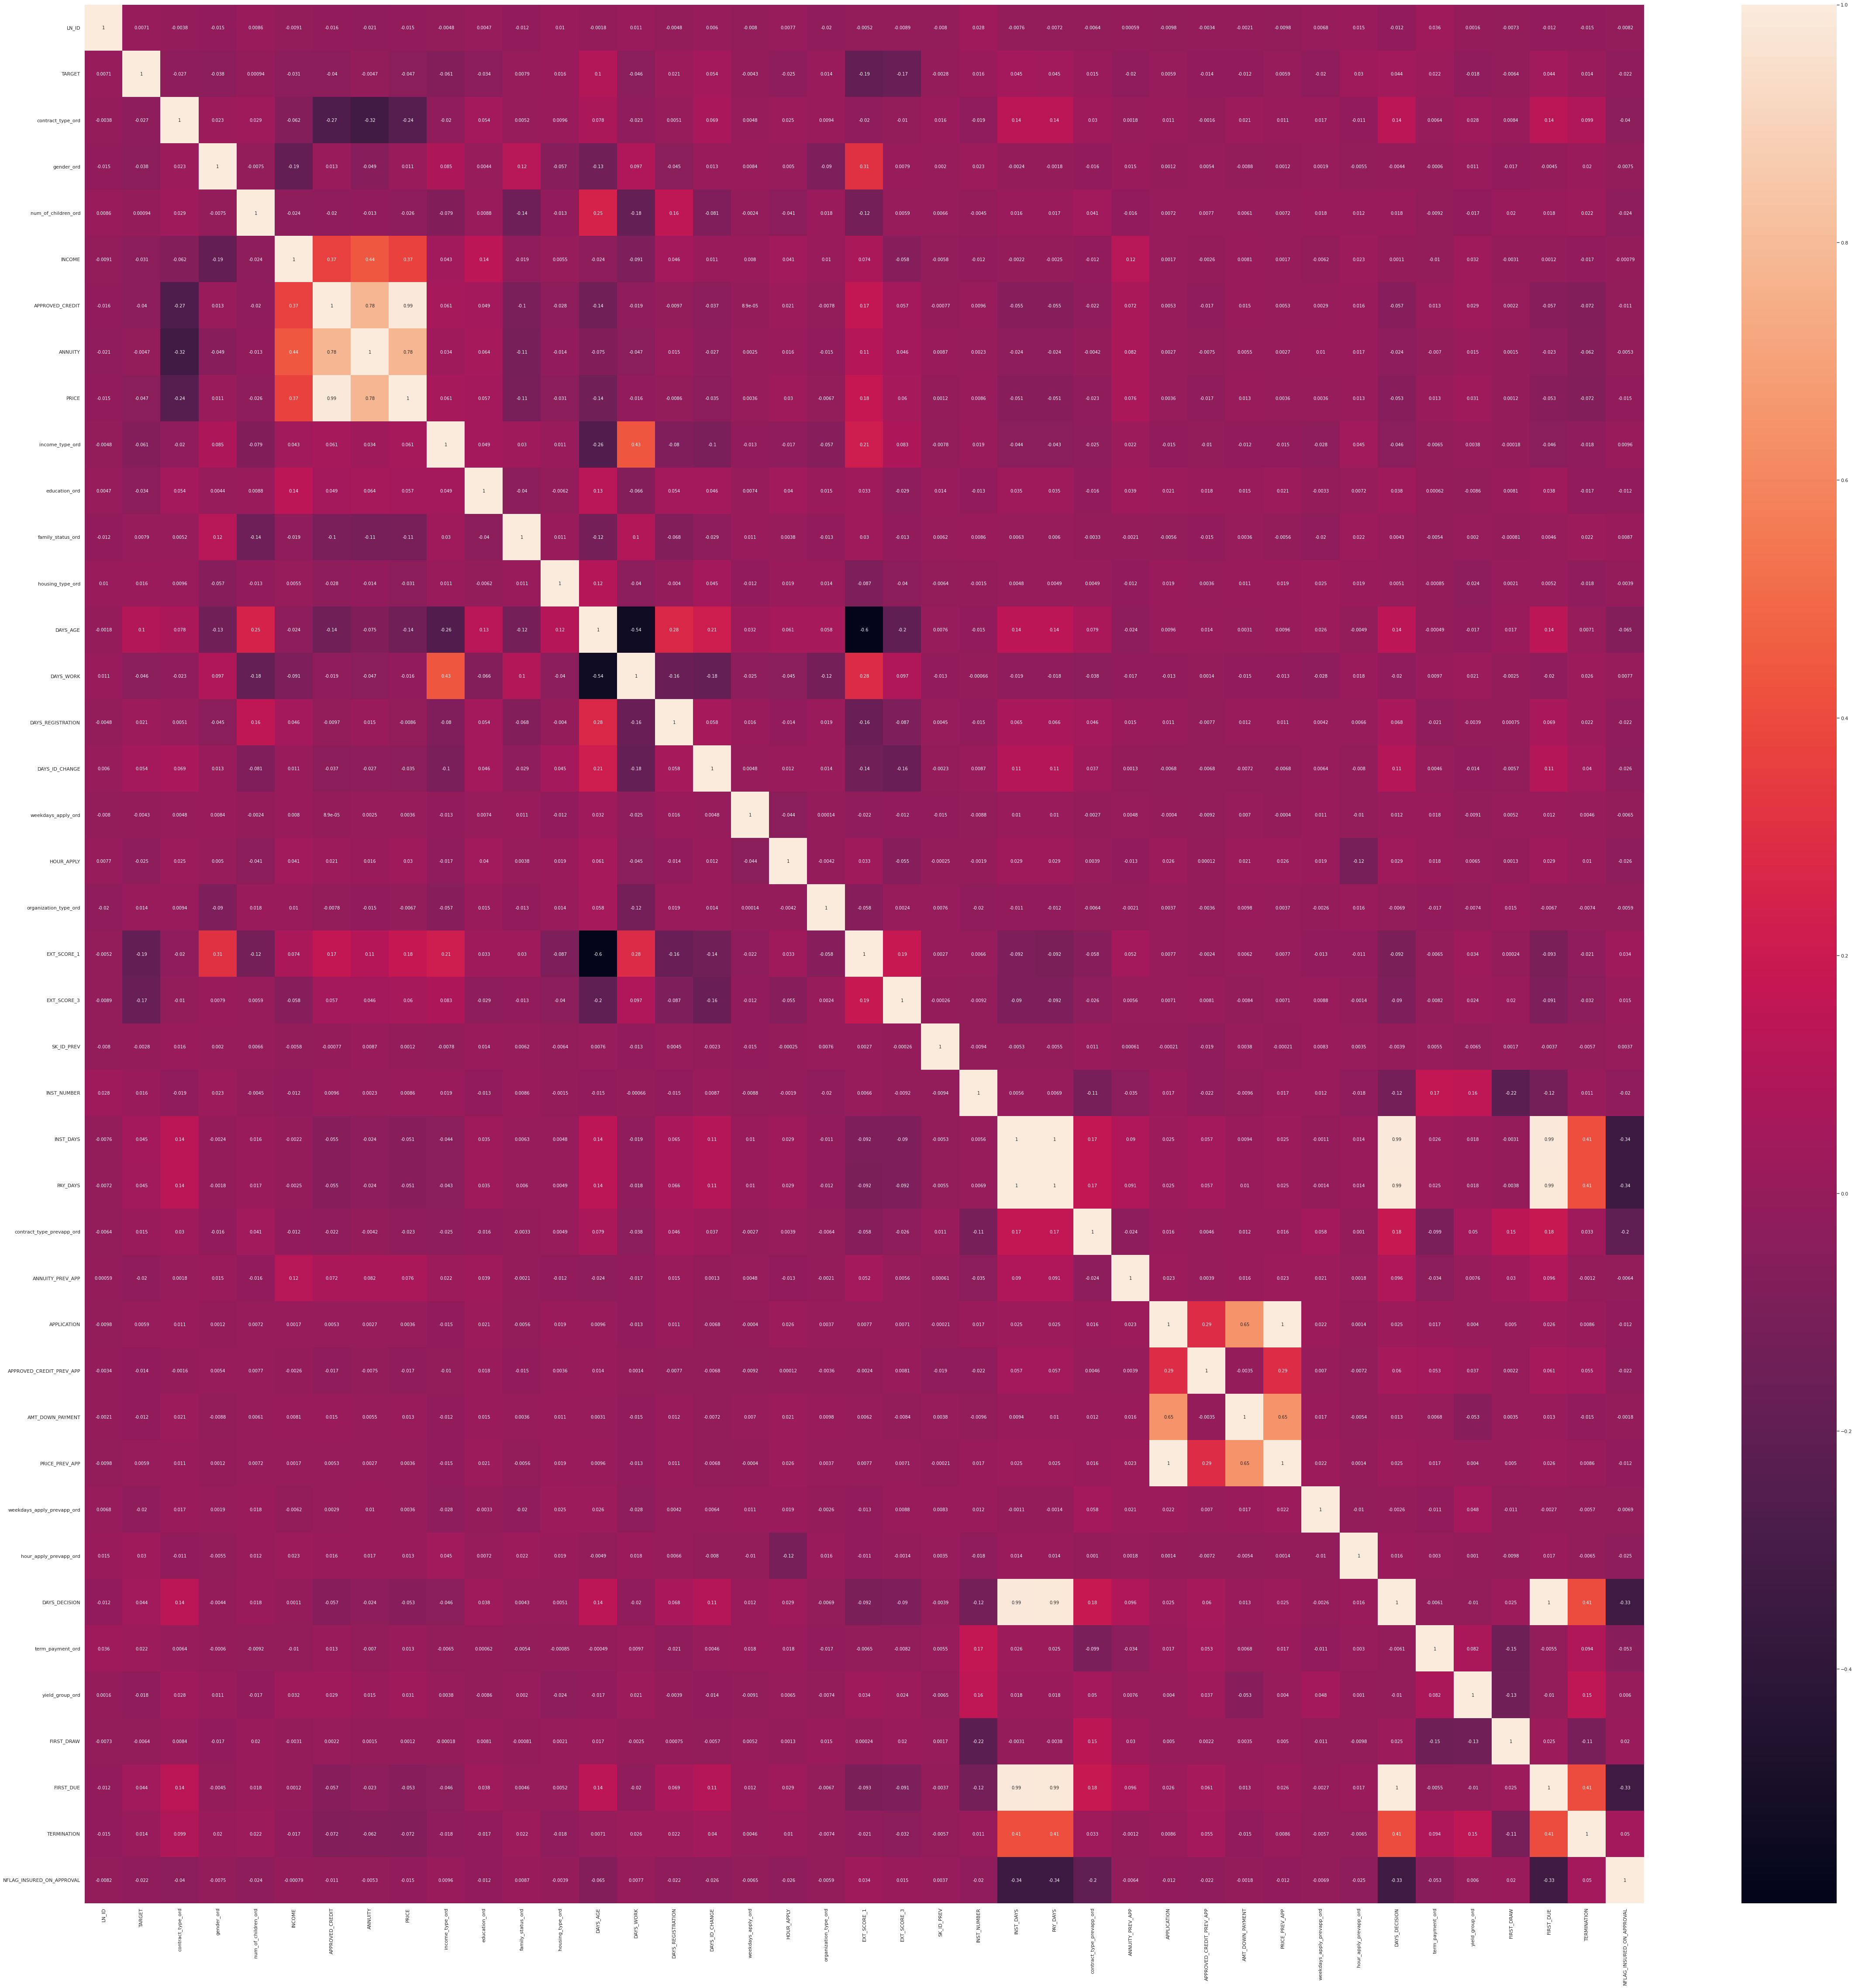

In [44]:
corr_mtx = df_new_test_train.corr()

plt.figure(figsize = (80,80))
sns.heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True)
plt.show()

In [58]:
sns.pairplot(df_new_test_train, palette='coolwarm')

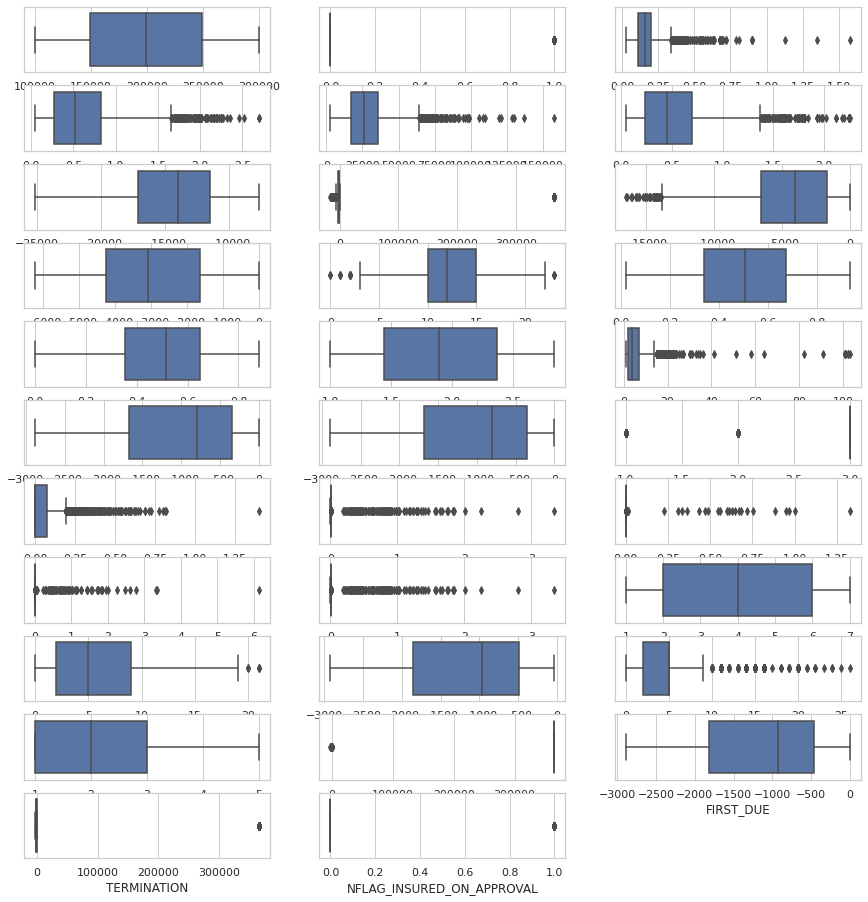

In [85]:
# get all numerical columns
# num_col = df.select_dtypes('number').columns

num_col = ['LN_ID', 'TARGET', 'INCOME', 'APPROVED_CREDIT', 
           'ANNUITY', 'PRICE', 'DAYS_AGE', 'DAYS_WORK', 'DAYS_REGISTRATION', 
           'DAYS_ID_CHANGE', 'HOUR_APPLY', 'EXT_SCORE_1', 'EXT_SCORE_3',
           'SK_ID_PREV', 'INST_NUMBER', 'INST_DAYS', 'PAY_DAYS', 
           'contract_type_prevapp_ord', 'ANNUITY_PREV_APP',
           'APPLICATION', 'APPROVED_CREDIT_PREV_APP', 'AMT_DOWN_PAYMENT',
           'PRICE_PREV_APP', 'weekdays_apply_prevapp_ord',
           'hour_apply_prevapp_ord', 'DAYS_DECISION', 'term_payment_ord',
           'yield_group_ord', 'FIRST_DRAW', 'FIRST_DUE', 'TERMINATION',
           'NFLAG_INSURED_ON_APPROVAL']

plt.figure(figsize=(15, 20))
pos = 1

# Loops for numerical feature 
for i in num_col:
    plt.subplot(14, 3, pos)
    sns.boxplot(data=df_new_test_train, x=i)
    pos += 1

# 'contract_type_ord', ,'gender_ord', 'num_of_children_ord', 'income_type_ord', 'education_ord', 'family_status_ord', 'housing_type_ord', 'weekdays_apply_ord', 
# 'organization_type_ord', 'EXT_SCORE_2', 'AMT_INST', 'AMT_PAY', 

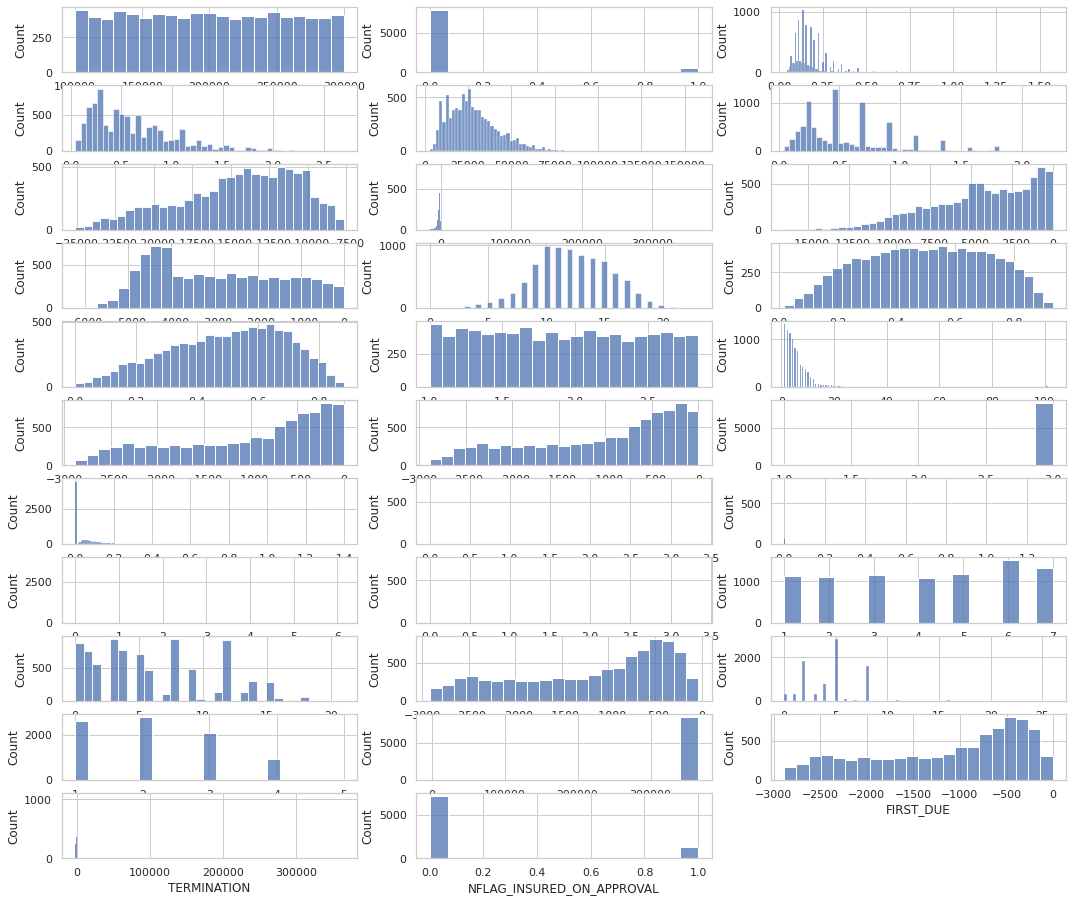

In [87]:
plt.figure(figsize=(18, 20))
pos = 1

# Loops for numerical feature 
for i in num_col:
    plt.subplot(14, 3, pos)
    sns.histplot(data=df_new_test_train, x=i)
    pos += 1

## **2. Feature Selection :**  
Correlation Analysis, Random Forrest, and SelectKBest (f_classif)

In [49]:
# Feature selection using SelectKBest
X = df_new_test_train[['LN_ID', 'contract_type_ord','gender_ord', 'num_of_children_ord',                      'INCOME','APPROVED_CREDIT', 'ANNUITY', 'PRICE', 'income_type_ord', 'education_ord',
       'family_status_ord', 'housing_type_ord', 'DAYS_AGE', 'DAYS_WORK',
       'DAYS_REGISTRATION', 'DAYS_ID_CHANGE', 'weekdays_apply_ord', 'HOUR_APPLY',
       'organization_type_ord', 'EXT_SCORE_1', 'EXT_SCORE_2', 'EXT_SCORE_3',
       'SK_ID_PREV', 'INST_NUMBER', 'INST_DAYS', 'PAY_DAYS', 
       'AMT_INST', 'AMT_PAY', 'contract_type_prevapp_ord', 'ANNUITY_PREV_APP', 
       'APPLICATION', 'APPROVED_CREDIT_PREV_APP', 'AMT_DOWN_PAYMENT', 'PRICE_PREV_APP',
       'weekdays_apply_prevapp_ord', 'hour_apply_prevapp_ord', 'DAYS_DECISION', 'term_payment_ord', 
       'yield_group_ord', 'FIRST_DRAW', 'FIRST_DUE', 'TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL']]
y = df_new_test_train['TARGET']  


In [50]:
X.dtypes

LN_ID                           int64
contract_type_ord               int64
gender_ord                      int64
num_of_children_ord           float64
INCOME                        float64
APPROVED_CREDIT               float64
ANNUITY                       float64
PRICE                         float64
income_type_ord               float64
education_ord                   int64
family_status_ord               int64
housing_type_ord                int64
DAYS_AGE                        int64
DAYS_WORK                       int64
DAYS_REGISTRATION               int64
DAYS_ID_CHANGE                  int64
weekdays_apply_ord              int64
HOUR_APPLY                      int64
organization_type_ord           int64
EXT_SCORE_1                   float64
EXT_SCORE_2                    object
EXT_SCORE_3                   float64
SK_ID_PREV                    float64
INST_NUMBER                   float64
INST_DAYS                     float64
PAY_DAYS                      float64
AMT_INST    

In [ ]:
lbl = LabelEncoder()
X['EXT_SCORE_2'] = lbl.fit_transform(X['EXT_SCORE_2'].astype(float))
X['AMT_INST'] = lbl.fit_transform(X['AMT_INST'].astype(float))
X['AMT_PAY'] = lbl.fit_transform(X['AMT_PAY'].astype(float))

In [52]:
X.head()

,LN_ID,contract_type_ord,gender_ord,num_of_children_ord,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,income_type_ord,education_ord,...,PRICE_PREV_APP,weekdays_apply_prevapp_ord,hour_apply_prevapp_ord,DAYS_DECISION,term_payment_ord,yield_group_ord,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,145235,1,1,1.0,202500.0,728460.0,44694.0,675000.0,2.0,1,...,62955.0,7.0,0,-261.0,0,3.0,365243.0,-231.0,-16.0,1.0
1,156401,1,2,2.0,225000.0,640080.0,31261.5,450000.0,1.0,1,...,64039.5,5.0,1,-978.0,1,1.0,365243.0,-947.0,-850.0,0.0
10,186361,1,2,2.0,270000.0,906615.0,30091.5,688500.0,2.0,2,...,34353.0,6.0,2,-1964.0,2,2.0,365243.0,-1929.0,-1774.0,0.0
14,255272,1,1,1.0,247500.0,622413.0,33894.0,495000.0,1.0,3,...,91791.0,6.0,3,-463.0,3,1.0,365243.0,-432.0,365243.0,0.0
16,123747,1,2,1.0,112500.0,720000.0,25506.0,720000.0,1.0,1,...,57919.5,6.0,4,-536.0,4,4.0,365243.0,-505.0,365243.0,0.0


In [53]:
y.head()

0     0
1     0
10    0
14    0
16    1
Name: TARGET, dtype: int64

In [54]:
print(X.shape)
print(y.shape)

(8477, 43)
(8477,)


In [ ]:
# Apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=10)  # https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
# best = bestfeatures.fit(x,y)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(best.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] 
print(featureScores.nlargest(10,'Score'))

              Specs       Score
19      EXT_SCORE_1  311.627961
21      EXT_SCORE_3  243.185441
12         DAYS_AGE   88.463563
8   income_type_ord   32.061819
15   DAYS_ID_CHANGE   24.892573
7             PRICE   18.723380
13        DAYS_WORK   17.923287
24        INST_DAYS   17.544501
25         PAY_DAYS   17.273581
40        FIRST_DUE   16.443101


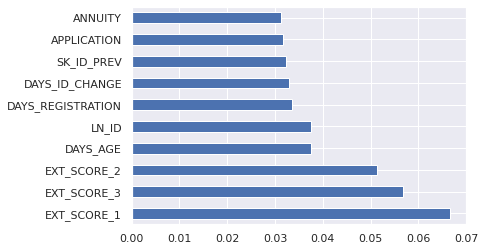

In [ ]:
# Randomforest
rf_model = RandomForestClassifier()
rf_model.fit(X,y)
feat_importances = pd.Series(rf_model.feature_importances_, index=x.columns)
df_imp_feat = feat_importances.nlargest(10)
df_imp_feat.plot(kind='barh')
plt.show()

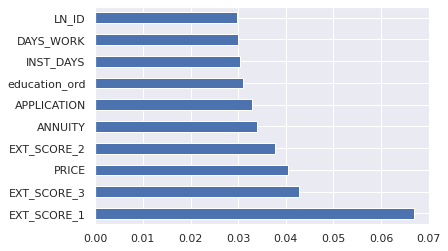

In [ ]:
# Xgboost
xgb_clf = XGBClassifier()
xgb_clf.fit(X, y)
feat_importances = pd.Series(xgb_clf.feature_importances_, index=x.columns)
df_imp_feat = feat_importances.nlargest(10)
df_imp_feat.plot(kind='barh')
plt.show()

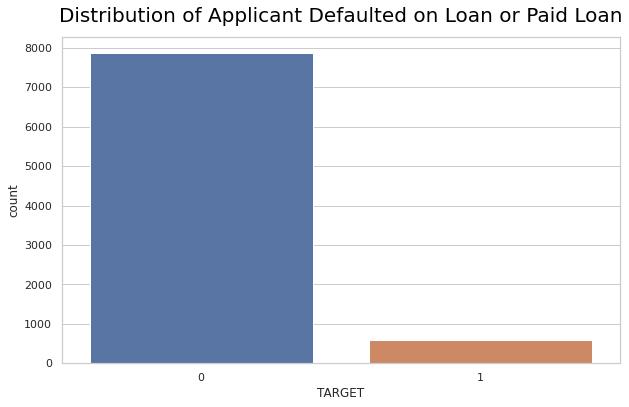

In [88]:
# Plotting distribution of applicant due loan
plt.figure(figsize = (10, 6))
sns.countplot(data = df_new_test_train, x='TARGET')
plt.title('Distribution of Applicant Defaulted on Loan or Paid Loan', fontsize=20, color='black', pad=15)
plt.show()

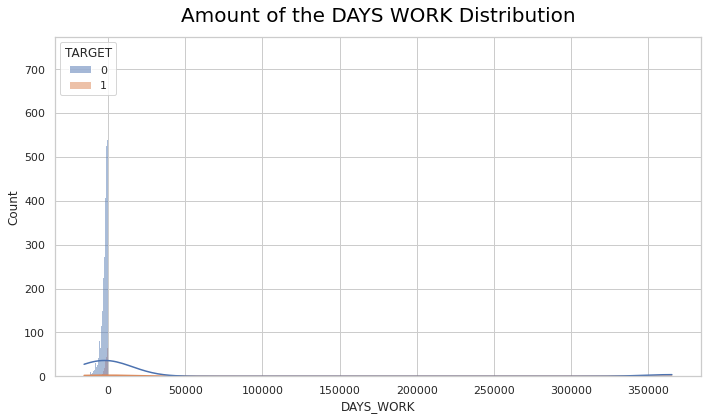

In [89]:
# Plotting amount of the loan DAYS WORK distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_new_test_train, x='DAYS_WORK', kde=True, hue='TARGET')
plt.title('Amount of the DAYS WORK Distribution', fontsize=20, color='black', pad=15)
plt.tight_layout()
plt.show()

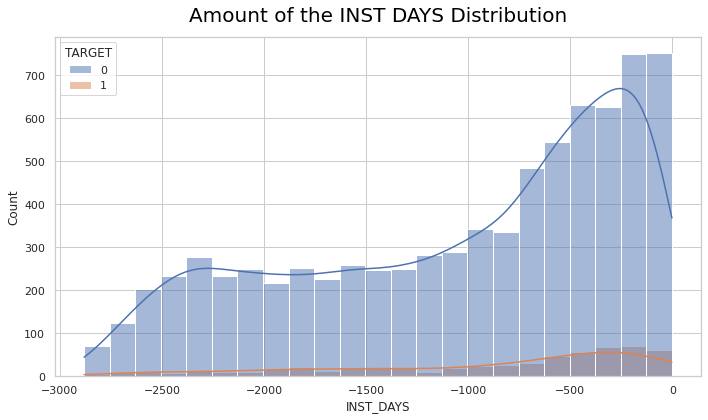

In [90]:
# Plotting amount of the DAYS WORK distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_new_test_train, x='INST_DAYS', kde=True, hue='TARGET')
plt.title('Amount of the INST DAYS Distribution', fontsize=20, color='black', pad=15)
plt.tight_layout()
plt.show()

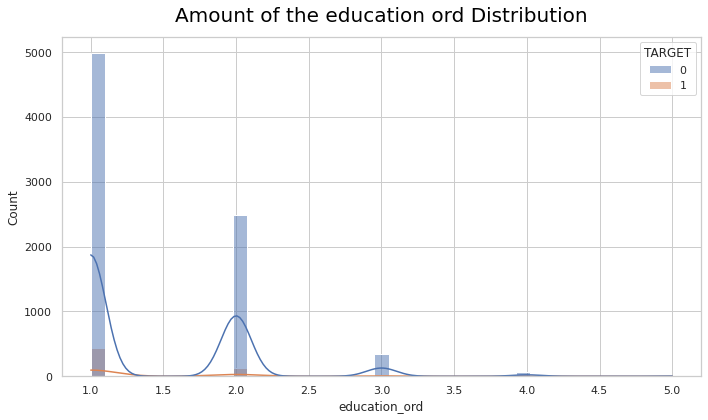

In [91]:
# Plotting amount of the education ord distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_new_test_train, x='education_ord', kde=True, hue='TARGET')
plt.title('Amount of the education ord Distribution', fontsize=20, color='black', pad=15)
plt.tight_layout()
plt.show()

In [36]:
df_new_test_train['APPLICATION'] = lbl.fit_transform(df_new_test_train['APPLICATION'].astype(float))

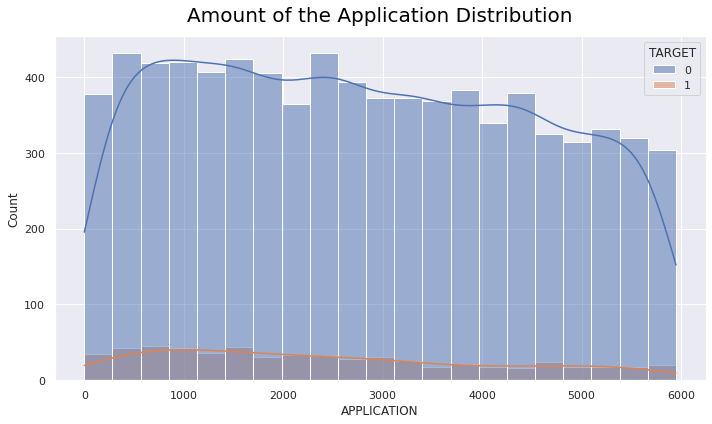

In [37]:
# Plotting amount of the Application distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_new_test_train, x='APPLICATION', kde=True, hue='TARGET')
plt.title('Amount of the Application Distribution', fontsize=20, color='black', pad=15)
plt.tight_layout()
plt.show()

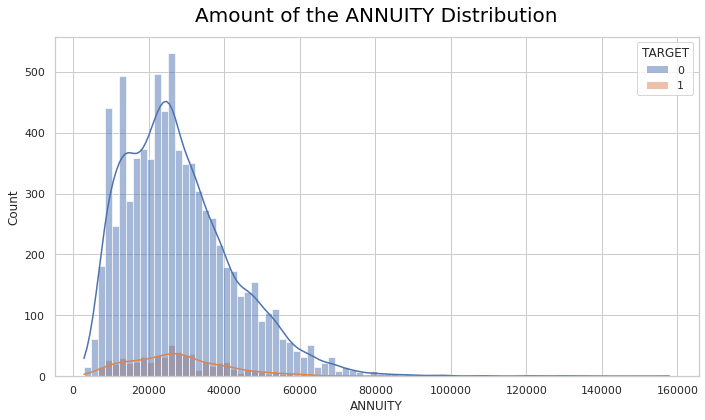

In [93]:
# Plotting amount of the ANNUITY distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_new_test_train, x='ANNUITY', kde=True, hue='TARGET')
plt.title('Amount of the ANNUITY Distribution', fontsize=20, color='black', pad=15)
plt.tight_layout()
plt.show()

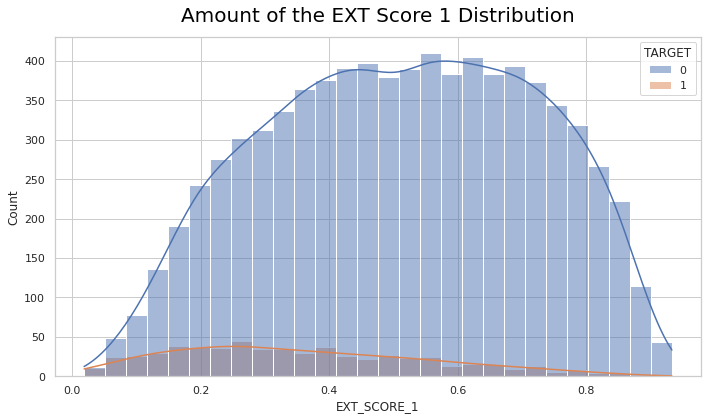

In [94]:
# Plotting amount of the EXT Score 1 distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_new_test_train, x='EXT_SCORE_1', kde=True, hue='TARGET')
plt.title('Amount of the EXT Score 1 Distribution', fontsize=20, color='black', pad=15)
plt.tight_layout()
plt.show()

In [34]:
df_new_test_train['EXT_SCORE_2'] = lbl.fit_transform(df_new_test_train['EXT_SCORE_2'].astype(float))

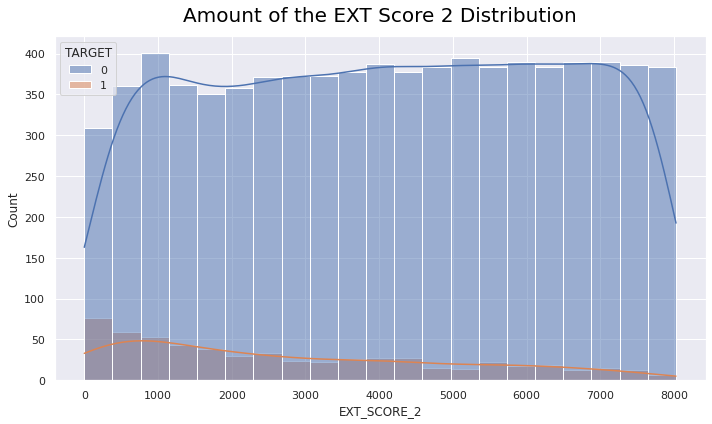

In [35]:
# Plotting amount of the EXT Score 2 distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_new_test_train, x='EXT_SCORE_2', kde=True, hue='TARGET')
plt.title('Amount of the EXT Score 2 Distribution', fontsize=20, color='black', pad=15)
plt.tight_layout()
plt.show()

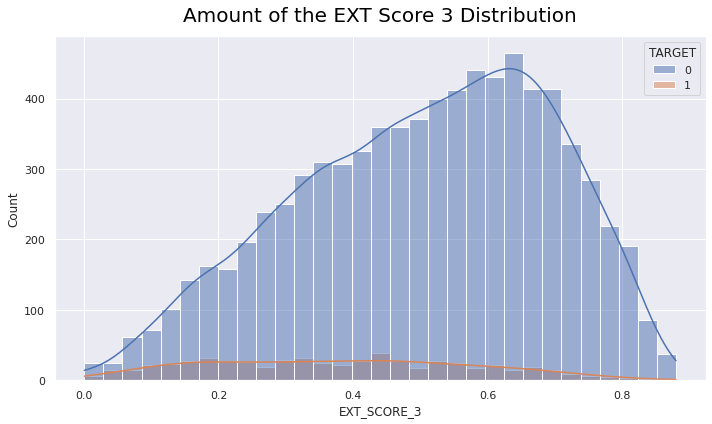

In [34]:
# Plotting amount of the EXT Score 3 distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_new_test_train, x='EXT_SCORE_3', kde=True, hue='TARGET')
plt.title('Amount of the EXT Score 3 Distribution', fontsize=20, color='black', pad=15)
plt.tight_layout()
plt.show()

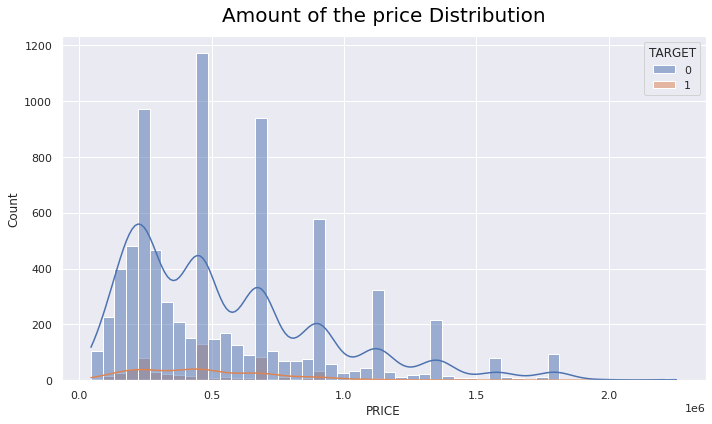

In [35]:
# Plotting amount of the PRICE distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_new_test_train, x='PRICE', kde=True, hue='TARGET')
plt.title('Amount of the price Distribution', fontsize=20, color='black', pad=15)
plt.tight_layout()
plt.show()

## Note :   
1. A random forest is made from multiple decision trees (as given by n_estimators). Each tree individually predicts for the new data and random forest spits out the mean prediction from those trees. The idea for confidence level of predictions is just to see how much predictions coming from different trees are varying for the new observations. Then to analyze further, we can seek some pattern for observations which have highest variability of predictions.
2. In most of the cases, random forests can beat linear models for prediction. An objection frequently raised for random forests is interpretation of results as compared to linear models. But one can address the misconceived objection using the discussed methodologies of interpretation.
3. Feature selection is also known as attribute selection is a process of extracting the most relevant features from the dataset and then applying machine learning algorithms for the better performance of the model. A large number of irrelevant features increases the training time exponentially and increase the risk of overfitting.
4. Chi-square Test for Feature Extraction:
Chi-square test is used for categorical features in a dataset. We calculate Chi-square between each feature and the target and select the desired number of features with best Chi-square scores. It determines if the association between two categorical variables of the sample would reflect their real association in the population.
5. ANOVA f-test Feature Selection, ANOVA is an acronym for “analysis of variance” and is a parametric statistical hypothesis test for determining whether the means from two or more samples of data (often three or more) come from the same distribution or not. An F-statistic, or F-test, is a class of statistical tests that calculate the ratio between variances values, such as the variance from two different samples or the explained and unexplained variance by a statistical test, like ANOVA. The ANOVA method is a type of F-statistic referred to here as an ANOVA f-test. Importantly, ANOVA is used when one variable is numeric and one is categorical, such as numerical input variables and a classification target variable in a classification task.

From the feature selection, we understand that;
'EXT_SCORE_1 is the most important feature in this credit risk modelling as followed by 'EXT_SCORE_3' and 'EXT_SCORE_2'

1. ฟอเรสต์สุ่มสร้างจากทรีการตัดสินใจหลายแบบ (ตามที่ n_estimators กำหนด) ต้นไม้แต่ละต้นจะทำนายข้อมูลใหม่ทีละต้น และป่าสุ่มแยกการทำนายเฉลี่ยจากต้นไม้เหล่านั้น แนวคิดสำหรับระดับความเชื่อมั่นในการทำนายคือเพื่อดูว่าการคาดคะเนที่มาจากต้นไม้ต่างกันมากน้อยเพียงใดสำหรับการสังเกตใหม่ จากนั้นเพื่อวิเคราะห์เพิ่มเติม เราสามารถหารูปแบบสำหรับการสังเกตที่มีความแปรปรวนของการคาดคะเนสูงสุด
  
2. ในกรณีส่วนใหญ่ ป่าสุ่มสามารถเอาชนะตัวแบบเชิงเส้นสำหรับการทำนายได้ การคัดค้านบ่อยครั้งสำหรับป่าสุ่มคือการตีความผลลัพธ์เมื่อเปรียบเทียบกับแบบจำลองเชิงเส้น แต่เราสามารถจัดการกับการคัดค้านที่เข้าใจผิดโดยใช้วิธีการตีความที่กล่าวถึง
  
3. การเลือกคุณลักษณะเรียกอีกอย่างว่าการเลือกแอตทริบิวต์เป็นกระบวนการดึงคุณลักษณะที่เกี่ยวข้องมากที่สุดออกจากชุดข้อมูล แล้วใช้อัลกอริทึมการเรียนรู้ของเครื่องเพื่อประสิทธิภาพที่ดีขึ้นของแบบจำลอง คุณลักษณะที่ไม่เกี่ยวข้องจำนวนมากจะเพิ่มเวลาการฝึกอบรมอย่างทวีคูณ และเพิ่มความเสี่ยงของการออกกำลังกายมากเกินไป
4. การทดสอบไคสแควร์สำหรับการสกัดคุณลักษณะ:
การทดสอบ Chi-square ใช้สำหรับคุณสมบัติการจัดหมวดหมู่ในชุดข้อมูล เราคำนวณ Chi-square ระหว่างแต่ละคุณสมบัติและเป้าหมาย และเลือกจำนวนคุณสมบัติที่ต้องการด้วยคะแนน Chi-square ที่ดีที่สุด เป็นตัวกำหนดว่าความสัมพันธ์ระหว่างตัวแปรตามหมวดหมู่สองตัวแปรของกลุ่มตัวอย่างจะสะท้อนถึงความสัมพันธ์ที่แท้จริงของพวกมันในประชากรหรือไม่

5. ANOVA f-test Feature Selection Selection ANOVA เป็นคำย่อของ "analysis of variance" และเป็นการทดสอบสมมติฐานทางสถิติแบบพาราเมตริกเพื่อพิจารณาว่าค่าเฉลี่ยจากตัวอย่างข้อมูลตั้งแต่สองตัวอย่างขึ้นไป (มักมีตั้งแต่ 3 ตัวอย่างขึ้นไป) มาจากการแจกแจงแบบเดียวกันหรือ ไม่. สถิติ F หรือการทดสอบ F เป็นคลาสของการทดสอบทางสถิติที่คำนวณอัตราส่วนระหว่างค่าความแปรปรวน เช่น ความแปรปรวนจากตัวอย่างที่แตกต่างกันสองตัวอย่าง หรือความแปรปรวนที่อธิบายและไม่ได้อธิบายโดยการทดสอบทางสถิติ เช่น ANOVA วิธีการ ANOVA เป็นประเภทของสถิติ F ที่อ้างถึงในที่นี้ว่า ANOVA f-test ที่สำคัญ ANOVA จะใช้เมื่อตัวแปรหนึ่งตัวเป็นตัวเลขและอีกตัวหนึ่งเป็นแบบจัดหมวดหมู่ เช่น ตัวแปรอินพุตที่เป็นตัวเลขและตัวแปรเป้าหมายการจัดหมวดหมู่ในงานจำแนกประเภท
จากการเลือกคุณสมบัติ เราเข้าใจดีว่า
'EXT_SCORE_1 เป็นคุณลักษณะที่สำคัญที่สุดในแบบจำลองความเสี่ยงด้านเครดิตนี้ ตามด้วย 'EXT_SCORE_3' และ 'EXT_SCORE_2'
4. การทดสอบไคสแควร์สำหรับการสกัดคุณลักษณะ:
การทดสอบ Chi-square ใช้สำหรับคุณสมบัติการจัดหมวดหมู่ในชุดข้อมูล เราคำนวณ Chi-square ระหว่างแต่ละคุณสมบัติและเป้าหมาย และเลือกจำนวนคุณสมบัติที่ต้องการด้วยคะแนน Chi-square ที่ดีที่สุด เป็นตัวกำหนดว่าความสัมพันธ์ระหว่างตัวแปรตามหมวดหมู่สองตัวแปรของกลุ่มตัวอย่างจะสะท้อนถึงความสัมพันธ์ที่แท้จริงของพวกมันในประชากรหรือไม่

5. ANOVA f-test Feature Selection Selection ANOVA เป็นคำย่อของ "analysis of variance" และเป็นการทดสอบสมมติฐานทางสถิติแบบพาราเมตริกเพื่อพิจารณาว่าค่าเฉลี่ยจากตัวอย่างข้อมูลตั้งแต่สองตัวอย่างขึ้นไป (มักมีตั้งแต่ 3 ตัวอย่างขึ้นไป) มาจากการแจกแจงแบบเดียวกันหรือ ไม่. สถิติ F หรือการทดสอบ F เป็นคลาสของการทดสอบทางสถิติที่คำนวณอัตราส่วนระหว่างค่าความแปรปรวน เช่น ความแปรปรวนจากตัวอย่างที่แตกต่างกันสองตัวอย่าง หรือความแปรปรวนที่อธิบายและไม่ได้อธิบายโดยการทดสอบทางสถิติ เช่น ANOVA วิธี ANOVA เป็นประเภทของสถิติ F ที่อ้างถึงในที่นี้ว่า ANOVA f-test ที่สำคัญ ANOVA จะใช้เมื่อตัวแปรหนึ่งตัวเป็นตัวเลขและอีกตัวหนึ่งเป็นแบบจัดหมวดหมู่ เช่น ตัวแปรอินพุตที่เป็นตัวเลขและตัวแปรเป้าหมายการจัดหมวดหมู่ในงานจำแนกประเภท
จากการเลือกคุณสมบัติ เราเข้าใจดีว่า
'EXT_SCORE_1 เป็นคุณลักษณะที่สำคัญที่สุดในแบบจำลองความเสี่ยงด้านเครดิตนี้ ตามด้วย 'EXT_SCORE_3' และ 'EXT_SCORE_2'